# Machine Learning: Differential Privacy Magnifies Bias

This Python notebook shows how differential privacy can magnify bias
in machine learning tasks like regression. The notebook covers reading
in data from a file, preparing the data for training, training the
classifier using IBM's Diffprivlib library, and observing issues with
bias.

As a running example, let's train a classifier for the Diverse Communities Data
Excerpts dataset curated by NIST and drawn from the US Census Bureau's American
Communities Survey (ACS).

## Step 1: Loading the Data

Before we start writing code, let's import a few third-party Python packages. We
will use `pandas` for creating and manipulating data frames, `numpy` for basic
operations over vectorized datatypes, `diffprivlib` for training a classifier
with differential privacy, and `matplotlib` for visualizing results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import diffprivlib.models as dp
import warnings

warnings.filterwarnings('ignore')

Our first step is to load the data. To do this we read the CSV file into a
dataframe object using `pandas`.

In [2]:
df = pd.read_csv('https://media.githubusercontent.com/media/usnistgov/SDNist/main/nist%20diverse%20communities%20data%20excerpts/massachusetts/ma2019.csv')

Let's display the data frame to get a sense for what the data looks like.

In [3]:
display(df)

,PUMA,AGEP,SEX,MSP,HISP,RAC1P,NOC,NPF,HOUSING_TYPE,OWN_RENT,...,PINCP,PINCP_DECILE,POVPIP,DVET,DREM,DPHY,DEYE,DEAR,PWGTP,WGTP
0,25-00503,18,1,6,0,1,N,N,3,0,...,5000.0,1,N,N,2,2,2,2,72,0
1,25-00703,21,2,6,0,1,N,N,3,0,...,0.0,0,N,N,2,2,2,2,6,0
2,25-00503,22,2,6,0,6,N,N,3,0,...,18000.0,3,N,N,2,2,2,2,80,0
3,25-01300,58,1,6,0,1,N,N,2,0,...,0.0,0,N,N,1,2,2,2,57,0
4,25-00703,18,2,6,0,1,N,N,3,0,...,3300.0,1,N,N,2,2,2,2,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7629,25-01300,8,1,N,0,1,2,3,1,1,...,N,N,501,N,2,2,2,2,45,41
7630,25-00703,14,1,N,0,1,1,3,1,1,...,N,N,501,N,2,2,2,2,115,114
7631,25-00503,3,1,N,0,6,2,4,1,1,...,N,N,347,N,N,N,2,2,69,75
7632,25-00503,1,2,N,0,6,2,4,1,1,...,N,N,347,N,N,N,2,2,64,75


## Step 2: Preprocess the Data for Training

To train a classifier, we need to separate the dataset into *features* and a
*label*. A well trained model will be able to predict the *label* for an entry
in the dataset based on the *features*. We call the feature dataset `X` and the
label dataset `y` following standard convention.

We have decided to use `'AGEP'` (age), `'SEX'` (sex), `'RAC1P'` (race) and
`'HOUSING_TYPE'` (single housing unit or group quarters such as dorms, barracks,
or nursing homes) as our features, and `'OWN_RENT'` (own or rent housing) as the
label for the model to predict.

In [4]:
X_train = df[['AGEP', 'SEX', 'RAC1P', 'HOUSING_TYPE']].to_numpy()
y_train = df['OWN_RENT'].to_numpy()

To observe bias, we are interested in comparing the accuracy of the
trained classifier for minority groups to its accuracy for the
majority group. For this purpose, we will consider the White
race—encoded as 1—as a majority group, and all other races—Black or
African American, American Indian, Alaska Native, Asian, Native
Hawaiian and Other Pacific Islander, some other race, and two or more
major race groups, encoded as 2–9 respectively—as minority groups.

In [5]:
majority_races = df['RAC1P'] == 1
minority_races = df['RAC1P'].isin([2,3,4,5,6,7,8,9])
print(f'There are {majority_races.sum()} records in the majority race category.')
print(f'There are {minority_races.sum()} records in the minority race categories.')

There are 6658 records in the majority race category.
There are 976 records in the minority race categories.


## Step 3: Train a classifier

To train a classifier we use the Gaussian Naive Bayes (GaussianNB) with
differential privacy implementation from IBM's `diffprivlib` library. We pick
the privacy parameter $\epsilon = 1$, fit the model, and then print out the
mean accuracy of the model.

In [6]:
dp_clf = dp.GaussianNB(epsilon=1.0)
dp_clf.fit(X_train, y_train)
print(dp_clf.score(X_train, y_train))

0.7991878438564317


## Step 4: Observe Accuracy for Minority Majority Groups

Our primary interest is to compare the accuracy of the model when predicting
labels for majority groups vs minority groups.

In [7]:
majority_accuracy = dp_clf.score(X_train[majority_races], y_train[majority_races])
minority_accuracy = dp_clf.score(X_train[minority_races], y_train[minority_races])
print(f'The observed accuracy for records with minority races is {majority_accuracy}.')
print(f'The observed accuracy for records with minority races is {minority_accuracy}.')

The observed accuracy for records with minority races is 0.820967257434665.
The observed accuracy for records with minority races is 0.6506147540983607.


As you can see, the accuracy is lower for minority groups than for the
majority group. This effect is due to the fact that the dataset
contains less data for the minority groups than it does for the
majority group, and it can be seen even when training without
differential privacy. However, differential privacy *magnifies* the
bias we see in the trained classifier, because the noise affects
smaller groups more than it does larger ones.

## Step 5: Observe Accuracy Difference when Varying Epsilon

To see the impact of differential privacy on the classifier's bias,
we'll vary the value of $\epsilon$. We plot the accuracy for majority
groups vs minority groups on the y-axis, with the $\epsilon$ used to
train the model on the x-axis.

(Creating the raw data for the plot takes more than a few seconds to generate.)

In [8]:
def experiment(epsilon):
    brs = []
    srs = []
    for _ in range(100):
        dp_clf = dp.GaussianNB(epsilon=epsilon)
        dp_clf.fit(X_train, y_train)
        brs.append(dp_clf.score(X_train[majority_races], y_train[majority_races]))
        srs.append(dp_clf.score(X_train[minority_races], y_train[minority_races]))
    return np.mean(brs), np.std(brs), np.mean(srs), np.std(srs)

xs = np.linspace(0.01, 0.2, 30)
results = [experiment(epsilon) for epsilon in xs]

Let's plot the results.

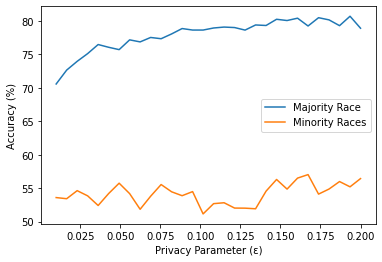

In [9]:
maj_avgs = [x[0]*100 for x in results]
min_avgs = [x[2]*100 for x in results]
maj_stds = [x[1] for x in results]
min_stds = [x[3] for x in results]
plt.plot(xs, maj_avgs, label='Majority Race')
plt.plot(xs, min_avgs, label='Minority Races')

plt.legend()
plt.xlabel('Privacy Parameter (ε)')
plt.ylabel('Accuracy (%)')
pass

As you can see, the disparity between accuracy for the minority and
majority groups gets worse as $\epsilon$ gets smaller—because noise
has more impact on smaller groups, and more noise makes this disparity
larger. Both results are noisy, due to the noise required by differential
privacy.

This general effect—where the accuracy for minority groups is lower than for
majority groups—is actually *always* present, even if we didn't train the model
with differential privacy. However, what this plot shows is that using
differential privacy *amplifies* the disadvantage for minority groups. As the
$\epsilon$ is increased, the graph shows accuracy improving on average for
majority groups, but very little improvement on average for minority groups.